## Goal of analysis script is to pull in Med-PC files from Pavlovian conditioning experiment and process for Pavlovian Conditioned Approach (PCA) parameters

In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import scipy as sp
import re
import os

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Functions

In [2]:
def get_file_info(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session (if subsession=True),
    #saves each accordingly
    
    path_split = file_path_name.split('/')
    file_split = path_split[-1].split('_')

    for row in file_split:

        if re.search(r'^\d\d\d\d\d\d$', row):
            date = row
        if re.search(r'^\d\d\d$', row):
            animal_number = row
        if re.search(r'\d$', row):
            session_num = row 
        
    session = session_num[:-1]

    return date, animal_number, session, session_num

In [3]:
def make_array_from_path(file_path_name):
    # takes in path, creates array (each row of array is a row from original med file)
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [4]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe


    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        if re.search(str(event_letter + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
        if re.search(str(time_letter + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    time_data.append(float(element))
                i = i + 1
        i = i + 1
    
    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [5]:
def get_trial_times(es_et, trial_start, trial_end, ITI_start, ITI_end):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for start and end of trial segment
    #e.g. conditioned stimulus onset and offset, ITI onset and offset
    #finds time_stamps for each start and end, puts into new dataframe

    start_time = es_et[es_et.event_stamp == trial_start]['time_stamp'].values
    end_time = es_et[es_et.event_stamp == trial_end]['time_stamp'].values
    start_time_ITI = es_et[es_et.event_stamp == ITI_start]['time_stamp'].values
    end_time_ITI = es_et[es_et.event_stamp == ITI_end]['time_stamp'].values
    
    cs_iti = pd.DataFrame(data = [start_time, end_time, start_time_ITI[0:len(start_time)], end_time_ITI[0:len(start_time)]])
    cs_iti = cs_iti.T
    cs_iti.columns = ['trial_start', 'trial_end', 'ITI_start', 'ITI_end']
    
    return cs_iti


In [6]:
def create_trials_df(es_et, cs_iti, trial_type):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    if trial_type == 'ITI':
        while i < len(cs_iti):
            data = es_et[(es_et['time_stamp'] >= cs_iti['ITI_start'][i]) & (es_et['time_stamp'] <= cs_iti['ITI_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['ITI_start'] = cs_iti['ITI_start'][i]
            data['ITI_end'] = cs_iti['ITI_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    elif trial_type == 'within':
        while i < len(cs_iti):
            data = es_et[(es_et['time_stamp'] >= cs_iti['trial_start'][i]) & (es_et['time_stamp'] <= cs_iti['trial_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['trial_start'] = cs_iti['trial_start'][i]
            data['trial_end'] = cs_iti['trial_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    
    return trial_data

In [21]:
#functions for analysis params

def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

def latency(trial_data, event_num, trial_type):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_ave = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
            latency_ave.append(np.nan)
        else:
            if trial_type == 'ITI':
                latency_1st.append((data['time_stamp'] - data['ITI_start']).values[0])
                latency_ave.append((data['time_stamp'] - data['ITI_start']).values.mean())
            elif trial_type == 'within':
                latency_1st.append((data['time_stamp'] - data['trial_start']).values[0])
                latency_ave.append((data['time_stamp'] - data['trial_start']).values.mean())
        i = i + 1
    
    return latency_1st, latency_ave

In [22]:
def create_session_df(trial_data, event_dic, trial_type):
    #use trial_data to compute selected parameters (from event_dic)
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    if trial_type == 'ITI':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['ITI_start'].unique(), trial_data.groupby('trial_#')['ITI_end'].unique()])
        times_df = times_df.T
    elif trial_type == 'within':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
        times_df = times_df.T  
        
    i = 0
    trial_times = []

    while i < times_df.shape[0]:
        if trial_type == 'ITI':
            trial_time = (times_df.iloc[i]['ITI_end'] - times_df.iloc[i]['ITI_start'])
        elif trial_type == 'within':
            trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_ave')] = latency(trial_data, event, trial_type)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times
    
    return session_data

### Analysis

#### Get data path info

In [23]:
path_1 = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav'
session_list_1 = os.listdir(path_1)
path_2 = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav'
session_list_2 = os.listdir(path_2)

file_paths = []
for file in session_list_1:
    file_path = path_1 + '/' + file
    file_paths.append(file_path)
for file in session_list_2:
    file_path = path_2 + '/' + file
    file_paths.append(file_path)
    
print(len(file_paths))
file_paths[0]

315


'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180618_266_Pav1'

#### Get animal info

In [24]:
#read animal info (lever assignment, group etc) into df

path_animal_info = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/assignments/pavlovian_round1and2.xlsx'
    
animal_info = pd.read_excel(path_animal_info)
animal_info = pd.DataFrame(data = animal_info)

animal_info.head()

,animal,group,lever
0,266,4,1.0
1,267,4,2.0
2,268,4,1.0
3,269,4,2.0
4,270,4,1.0


#### Compute trials data

##### Med PC program for pavlovian conditioning has the following event_stamps (array E):
-  Event stamps ( array E )
-   1   = Rt lever press/NP
-   2   = Lt lever press/NP
-   5   = Pellet reinforcement delivery
-   6   = Food tray head entry
-   7   = Right cue light on
-   8   = Left cue light on
-   9   = Right cue light off
-   10  = Left cue ight off
-   11  = Magazine tray light on
-   12  = Magazine tray light off
-   13  = Liquid delivery turns on
-   14  = Liquid delivery turns off
-   15  = ITI starts
-   16  = ITI ends
-   18  = Right lever extends
-   19  = Left lever extends
-   20  = Right lever retracts
-   21  = Left lever retracts
-   22  = CS on
-   23  = CS off
-   100 = Session termination
-   999 = Place holder - no event

##### Only within session

In [25]:
%%time
final_data_trials = pd.DataFrame()

bit_dic = {'right_lever': 1, 'left_lever': 2, 'HE': 6}

for file in file_paths:

    print(file) 
    
    #proccess file
    date, animal_number, session, session_num = get_file_info(file)
    array = make_array_from_path(file)
    es_et = get_events_and_times(array, "E", "T")
    cs_iti = get_trial_times(es_et, 22, 23, 15, 16)
    
    trial_data_within = create_trials_df(es_et, cs_iti, 'within')
    
    session_data = create_session_df(trial_data_within, bit_dic, 'within')
    
    #create pandas tidy df for within session
    session_data['type'] = ['session']*(session_data.shape[0])
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal_number'] = [animal_number]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['session_num'] = [session_num]*(session_data.shape[0])
    session_data['lever'] = int(animal_info[animal_info['animal'] == int(animal_number)]['lever'])
    session_data['group'] = int(animal_info[animal_info['animal'] == int(animal_number)]['group'])
    
    #select correct lever data for animal assignment
    if session_data['lever'][0] == 1:
        session_data['lever_count'] = session_data['right_lever_count']
        session_data['lever_latency_1st'] = session_data['right_lever_latency_1st']
        session_data['lever_latency_ave'] = session_data['right_lever_latency_ave']
        
    if session_data['lever'][0] == 2:
        session_data['lever_count'] = session_data['left_lever_count']
        session_data['lever_latency_1st'] = session_data['left_lever_latency_1st']
        session_data['lever_latency_ave'] = session_data['left_lever_latency_ave']
   
    session_data = session_data[['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever', 
                                 'trial_num', 'trial_duration', 
                                 'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                 'lever_count', 'lever_latency_1st', 'lever_latency_ave']]
    
    #add to final data frame
    final_data_trials = pd.concat([final_data_trials, session_data], axis = 0, ignore_index=True)

final_data_trials.head()

C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180618_266_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180618_268_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180618_269_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180618_270_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180618_271_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180618_273_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180618_274_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180618_275_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_box

C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180621_287_Pav4
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180621_288_Pav4
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180621_289_Pav4
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180621_290_Pav4
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180621_291_Pav3
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180621_292_Pav4
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180626_266_Pav5
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 1 6.2018/Pav/180626_267_Pav4
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_box

C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180918_360_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180918_362_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180918_363_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180918_364_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180918_365_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180918_366_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180918_368_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180918_371_Pav1
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_box

C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180921_364_Pav4
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180921_365_Pav4
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180921_367_Pav2
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180921_368_Pav3
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180921_369_Pav3
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180921_370_Pav3
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180921_371_Pav4
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180921_372_Pav4
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_box

C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180927_384_Pav7
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180927_385_Pav5
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180928_356_Pav6
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180928_356_Pav7
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180928_357_Pav7
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180928_363_Pav6
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180928_365_Pav7
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180928_367_Pav5
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_box

,type,date,session,session_num,animal_number,group,lever,trial_num,trial_duration,HE_count,HE_latency_1st,HE_latency_ave,lever_count,lever_latency_1st,lever_latency_ave
0,session,180618,Pav,Pav1,266,4,1,0,9.99,0,NaN,NaN,0,NaN,NaN
1,session,180618,Pav,Pav1,266,4,1,1,9.99,0,NaN,NaN,0,NaN,NaN
2,session,180618,Pav,Pav1,266,4,1,2,9.99,0,NaN,NaN,0,NaN,NaN
3,session,180618,Pav,Pav1,266,4,1,3,9.99,0,NaN,NaN,0,NaN,NaN
4,session,180618,Pav,Pav1,266,4,1,4,9.99,0,NaN,NaN,0,NaN,NaN


##### Within session and ITI

In [ ]:
%%time
final_data_trials = pd.DataFrame()

bit_dic = {'right_lever': 1, 'left_lever': 2, 'HE': 6}

for file in file_paths:

    print(file) 
    
    #proccess file
    date, animal_number, session, session_num = get_file_info(file)
    array = make_array_from_path(file)
    es_et = get_events_and_times(array, "E", "T")
    cs_iti = get_trial_times(es_et, 22, 23, 15, 16)
    
    trial_data_within = create_trials_df(es_et, cs_iti, 'within')
    trial_data_ITI = create_trials_df(es_et, cs_iti, 'ITI')
    
    session_data = create_session_df(trial_data_within, bit_dic, 'within')
    ITIsession_data = create_session_df(trial_data_ITI, bit_dic, 'ITI')
   
    #create pandas tidy df for within session
    session_data['type'] = ['session']*(session_data.shape[0])
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal_number'] = [animal_number]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['session_num'] = [session_num]*(session_data.shape[0])
    session_data['lever'] = int(animal_info[animal_info['animal'] == int(animal_number)]['lever'])
    session_data['group'] = int(animal_info[animal_info['animal'] == int(animal_number)]['group'])
    
    #select correct lever data for animal assignment
    if session_data['lever'][0] == 1:
        session_data['lever_count'] = session_data['right_lever_count']
        session_data['lever_latency_1st'] = session_data['right_lever_latency_1st']
        session_data['lever_latency_ave'] = session_data['right_lever_latency_ave']
        
    if session_data['lever'][0] == 2:
        session_data['lever_count'] = session_data['left_lever_count']
        session_data['lever_latency_1st'] = session_data['left_lever_latency_1st']
        session_data['lever_latency_ave'] = session_data['left_lever_latency_ave']
   
    session_data = session_data[['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever', 
                                 'trial_num', 'trial_duration', 
                                 'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                 'lever_count', 'lever_latency_1st', 'lever_latency_ave']]
    
    #create pandas tidy df for within ITI
    ITIsession_data['type'] = ['ITI']*(ITIsession_data.shape[0])
    ITIsession_data['date'] = [date]*(ITIsession_data.shape[0])
    ITIsession_data['animal_number'] = [animal_number]*(ITIsession_data.shape[0])
    ITIsession_data['session'] = [session]*(ITIsession_data.shape[0])
    ITIsession_data['session_num'] = [session_num]*(ITIsession_data.shape[0])
    ITIsession_data['lever'] = int(animal_info[animal_info['animal'] == int(animal_number)]['lever'])
    ITIsession_data['group'] = int(animal_info[animal_info['animal'] == int(animal_number)]['group'])
    
    #select correct lever data for animal assignment
    if ITIsession_data['lever'][0] == 1:
        ITIsession_data['lever_count'] = ITIsession_data['right_lever_count']
        ITIsession_data['lever_latency_1st'] = ITIsession_data['right_lever_latency_1st']
        ITIsession_data['lever_latency_ave'] = ITIsession_data['right_lever_latency_ave']
        
    if ITIsession_data['lever'][0] == 2:
        ITIsession_data['lever_count'] = ITIsession_data['left_lever_count']
        ITIsession_data['lever_latency_1st'] = ITIsession_data['left_lever_latency_1st']
        ITIsession_data['lever_latency_ave'] = ITIsession_data['left_lever_latency_ave']
   
    ITIsession_data = ITIsession_data[['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever', 
                                     'trial_num', 'trial_duration', 
                                     'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                     'lever_count', 'lever_latency_1st', 'lever_latency_ave']]
    #add to final data frame
    final_data_trials = pd.concat([final_data_trials, session_data, ITIsession_data], axis = 0, ignore_index=True)

final_data_trials.head()

#### Compute session data

##### PCA score based on:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0038987

"Using these measures we devised a “PCA Score”, as follows. From the CS lever deflections and CS food cup entries, we calculated three measures of approach: 

- 1) Response Bias (ratio of lever presses and food cup entries in relation to total number of responses)
- 2) Probability Difference (the difference between the probability of pressing the lever and the probability of entering the food cup)
- 3) Latency Score (difference between the latencies to approach the lever and the food cup). 

Averaging these three measures of approach produces a PCA Score for each individual, on each day of training. Scores derived this way range from −1 to +1, whereby scores of −1 and +1 indicate strong biases toward goal-tracking and sign-tracking, respectively, and a score of zero indicates that the two responses are equally distributed."

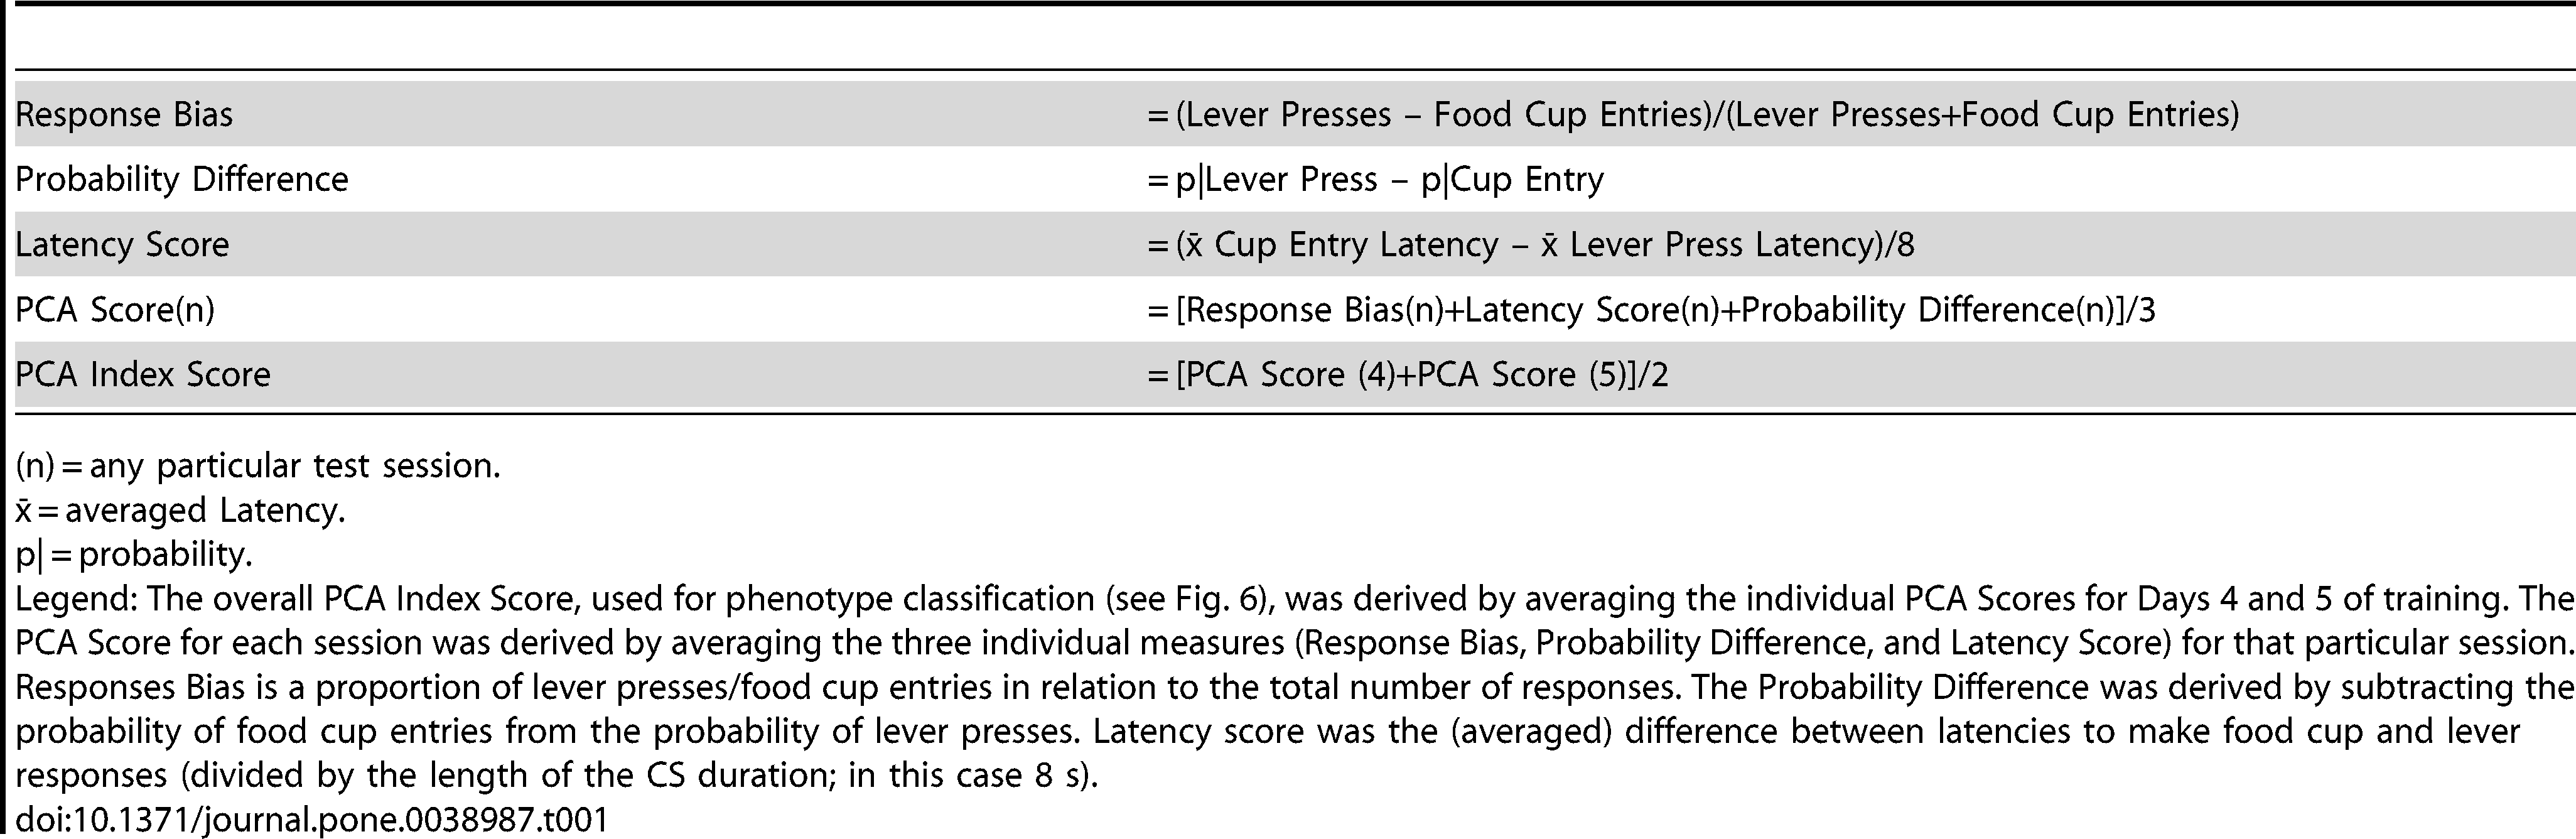

In [48]:
#get meta data
final_data_sessions = final_data_trials.groupby(['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever']).count()['trial_num'].reset_index()

#compute lever presses, food entries, response bias
final_data_sessions['lever_press_sum'] = final_data_trials.groupby(['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever'])['lever_count'].sum().reset_index(name='lever_count')['lever_count']
final_data_sessions['food_entry_sum'] = final_data_trials.groupby(['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever'])['HE_count'].sum().reset_index(name='HE_count')['HE_count']
final_data_sessions['response_bias'] = ((final_data_sessions['lever_press_sum'] - final_data_sessions['food_entry_sum']) / (final_data_sessions['lever_press_sum'] + final_data_sessions['food_entry_sum'])).reset_index(name='response_bias')['response_bias']

#compute count of trials with at least 1 lever press, head entry; compute response probs
lever_press_trial_count = final_data_trials[final_data_trials['lever_count'] != 0].groupby(['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever'])['lever_count'].count().reset_index(name='lever_press_trial_count')
head_entry_trial_count = final_data_trials[final_data_trials['HE_count'] != 0].groupby(['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever'])['HE_count'].count().reset_index(name='head_entry_trial_count')
final_data_sessions = pd.merge(final_data_sessions, lever_press_trial_count, how='left', on=['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever'])
final_data_sessions = pd.merge(final_data_sessions, head_entry_trial_count, how='left', on=['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever']).replace(np.nan, 0)
final_data_sessions['lever_press_prob'] = (final_data_sessions['lever_press_trial_count'] / 25).replace(np.nan, 0)
final_data_sessions['head_entry_prob'] = (final_data_sessions['head_entry_trial_count'] / 25).replace(np.nan, 0)
final_data_sessions['prob_diff'] = final_data_sessions['lever_press_prob'] - final_data_sessions['head_entry_prob']

#compute latency diffs
final_data_sessions['lever_press_lat'] = final_data_trials.groupby(['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever'])['lever_latency_1st'].mean().reset_index(name='lever_latency_mean')['lever_latency_mean']
final_data_sessions['food_entry_lat'] = final_data_trials.groupby(['type', 'date', 'session', 'session_num', 'animal_number', 'group', 'lever'])['HE_latency_1st'].mean().reset_index(name='HE_latency_mean')['HE_latency_mean']
final_data_sessions['latency_score'] = ((final_data_sessions['food_entry_lat'] - final_data_sessions['lever_press_lat'])/10).reset_index(name='latency_score')['latency_score']

#compute PCA score
final_data_sessions['PCA_score'] = (final_data_sessions['response_bias'] + final_data_sessions['prob_diff'] + final_data_sessions['latency_score']) / 3

#add column for round
final_data_sessions['round'] = [1 if x < 300 else 2 for x in final_data_sessions['animal_number'].astype('int')]

#add column for PCA group - based on PCA_score from last 2 sessions
PCA_56 = final_data_sessions[final_data_sessions['session_num'].isin(['Pav6', 'Pav7'])].groupby('animal_number')['PCA_score'].mean().reset_index(name='PCA_56')
PCA_56['PCA_group'] = ['ST' if x >= 0.25 else 'GT' if x <= -0.25 else 'Int' for x in PCA_56['PCA_56']]
final_data_sessions = pd.merge(final_data_sessions, PCA_56, how='left', on=['animal_number'])

print(final_data_sessions.shape)
final_data_sessions.head()

(315, 23)


,type,date,session,session_num,animal_number,group,lever,trial_num,lever_press_sum,food_entry_sum,response_bias,lever_press_trial_count,head_entry_trial_count,lever_press_prob,head_entry_prob,prob_diff,lever_press_lat,food_entry_lat,latency_score,PCA_score,round,PCA_56,PCA_group
0,session,180618,Pav,Pav1,266,4,1,25,4,1,0.600000,3.0,1.0,0.12,0.04,0.08,4.146667,5.070,0.092333,0.257444,1,-0.304671,GT
1,session,180618,Pav,Pav1,268,4,1,25,6,1,0.714286,5.0,1.0,0.20,0.04,0.16,5.916000,4.590,-0.132600,0.247229,1,0.049093,Int
2,session,180618,Pav,Pav1,269,4,2,25,5,0,1.000000,3.0,0.0,0.12,0.00,0.12,4.266667,NaN,NaN,NaN,1,NaN,Int
3,session,180618,Pav,Pav1,270,4,1,25,6,6,0.000000,5.0,4.0,0.20,0.16,0.04,3.494000,2.255,-0.123900,-0.027967,1,-0.527425,GT
4,session,180618,Pav,Pav1,271,4,2,25,9,4,0.384615,5.0,2.0,0.20,0.08,0.12,3.558000,7.455,0.389700,0.298105,1,-0.190303,Int


In [56]:
final_data_sessions.to_csv('final_data_sessions.csv')

### Viz

lever_press_sum


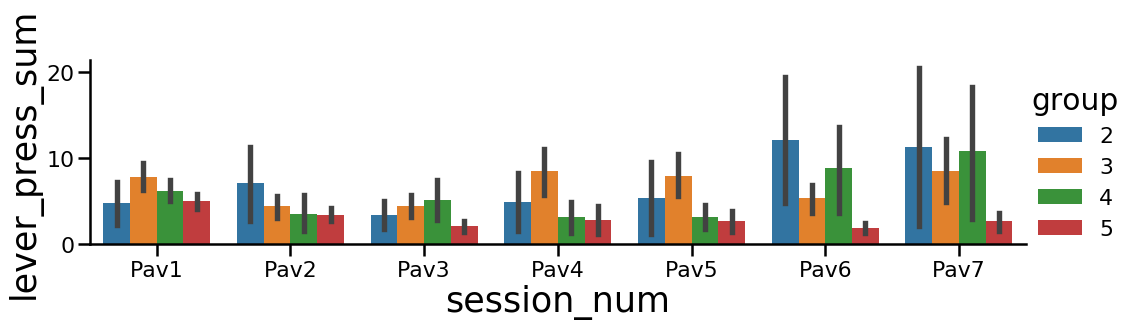

food_entry_sum


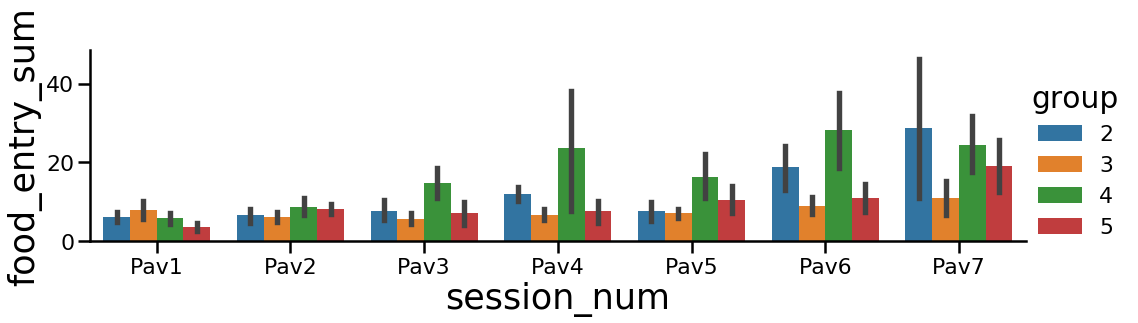

response_bias


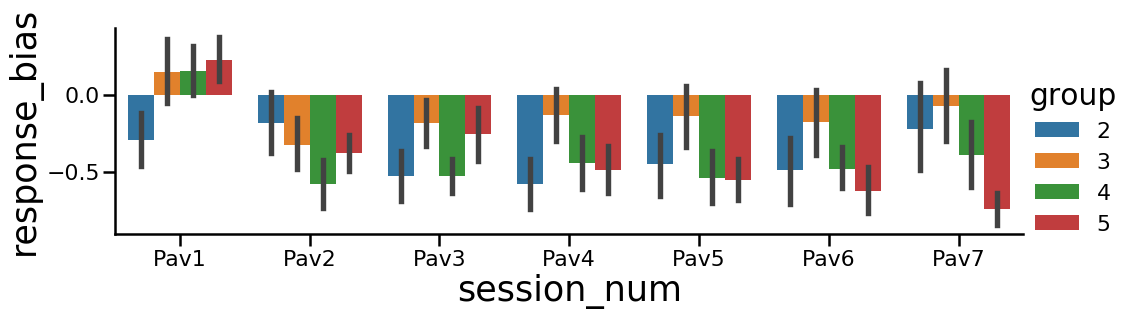

lever_press_trial_count


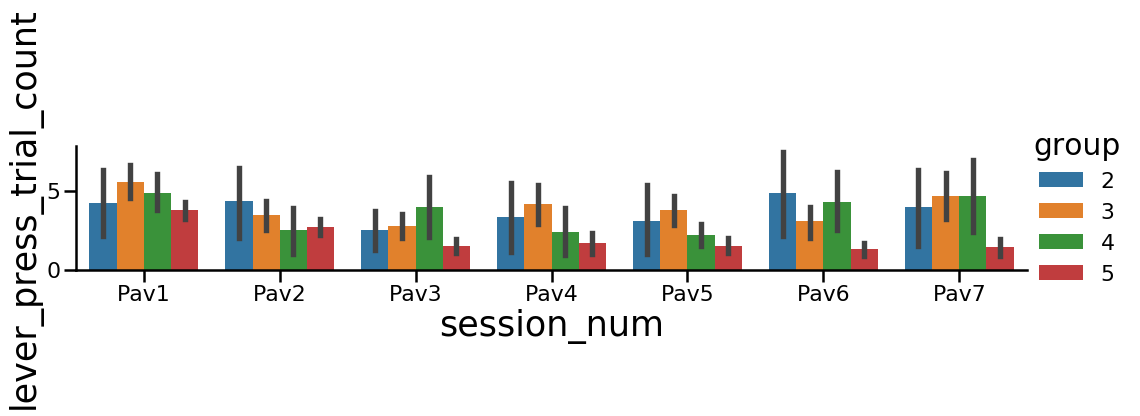

head_entry_trial_count


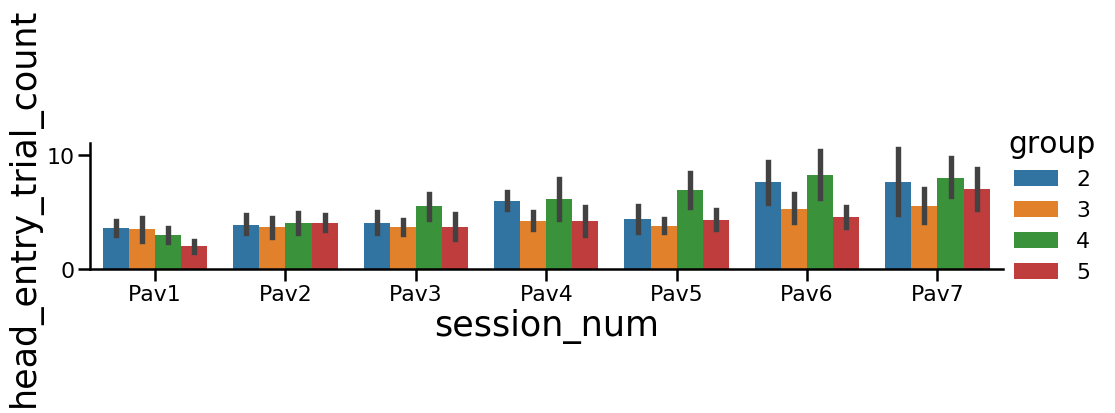

lever_press_prob


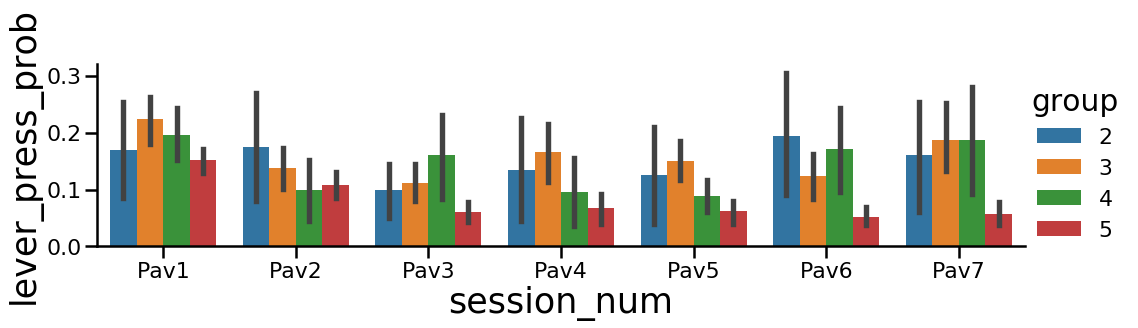

head_entry_prob


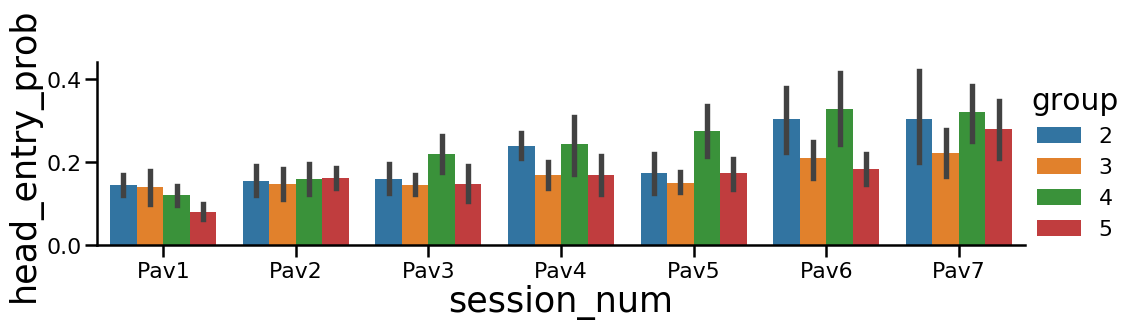

prob_diff


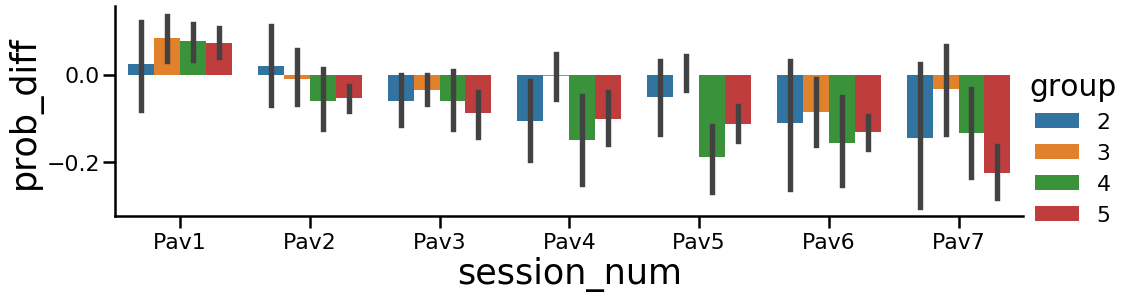

lever_press_lat


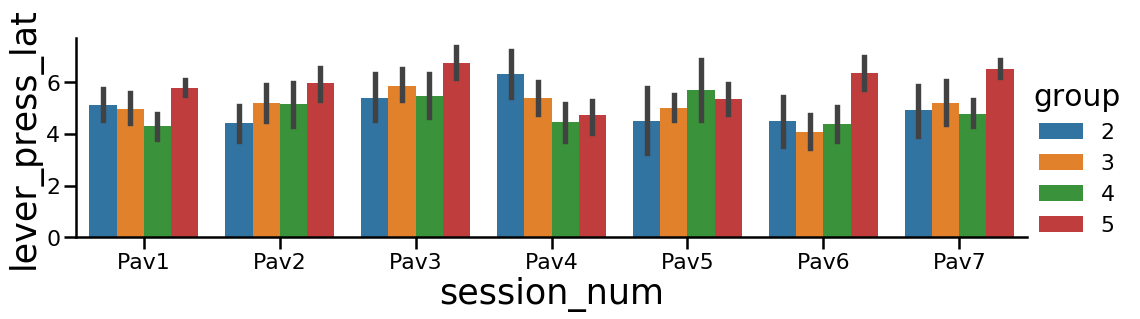

food_entry_lat


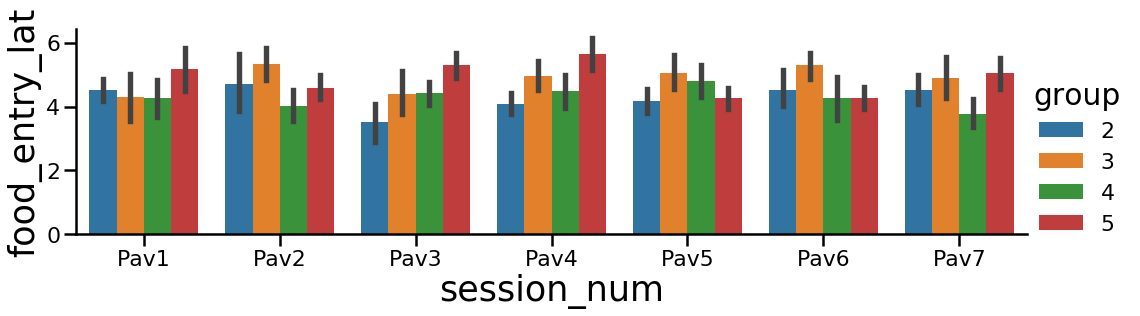

latency_score


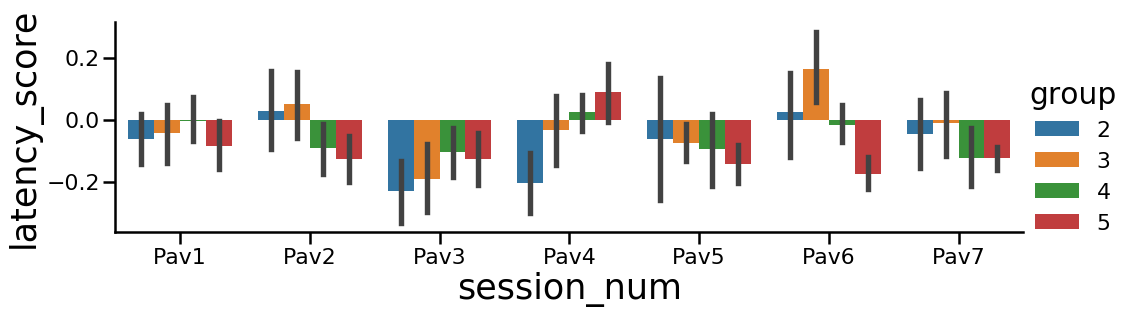

PCA_score


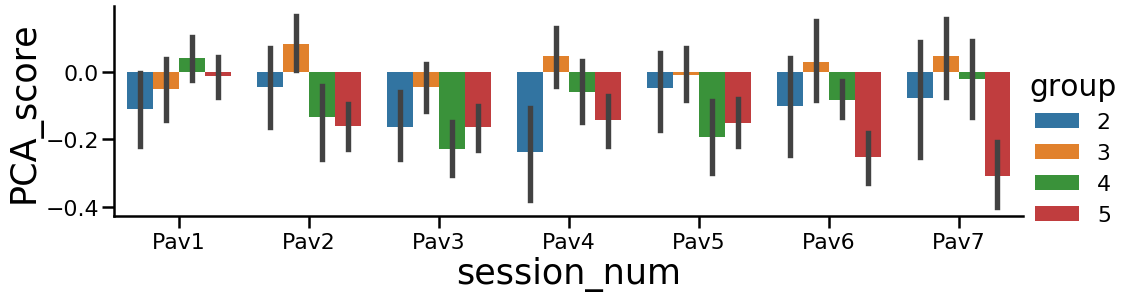

In [57]:
final_data_sessions_sessions = final_data_sessions[final_data_sessions['type'] == 'session']

params = ['lever_press_sum', 'food_entry_sum', 'response_bias', 'lever_press_trial_count', 'head_entry_trial_count', 
          'lever_press_prob', 'head_entry_prob', 'prob_diff', 'lever_press_lat', 'food_entry_lat', 'latency_score', 
          'PCA_score']

for param in params:
    print(param)
    sns.catplot(x='session_num', y=param, data=final_data_sessions_sessions, hue='group', 
                kind='bar', height=5, aspect=3, ci=68)
    plt.show()


lever_press_sum


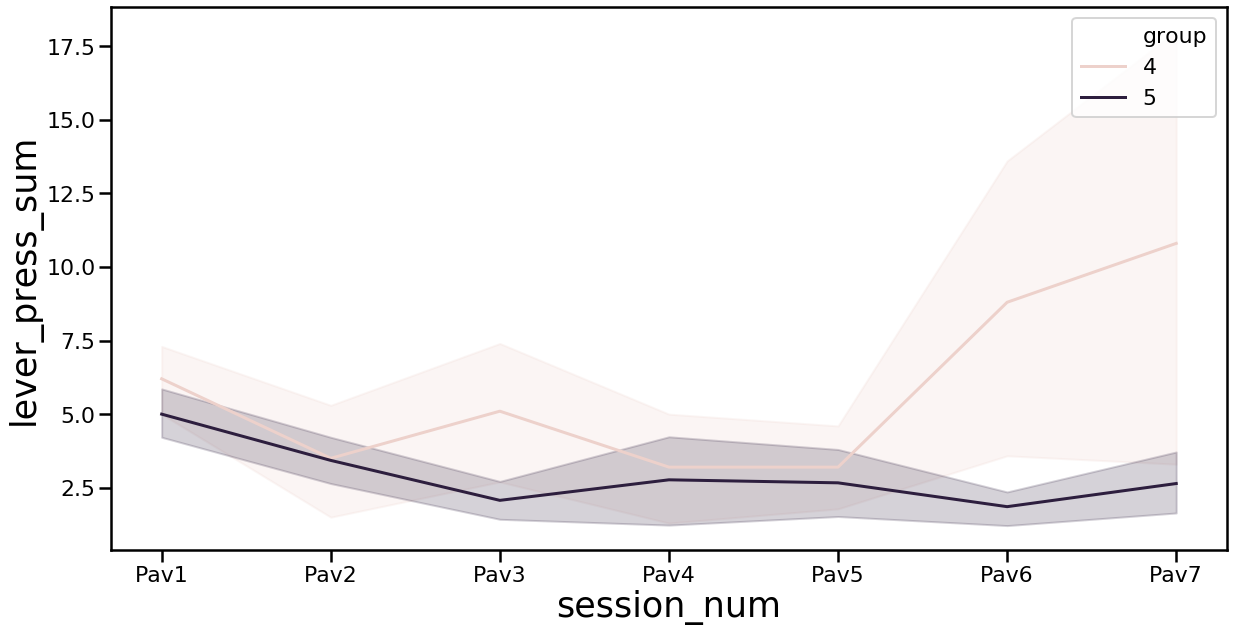

food_entry_sum


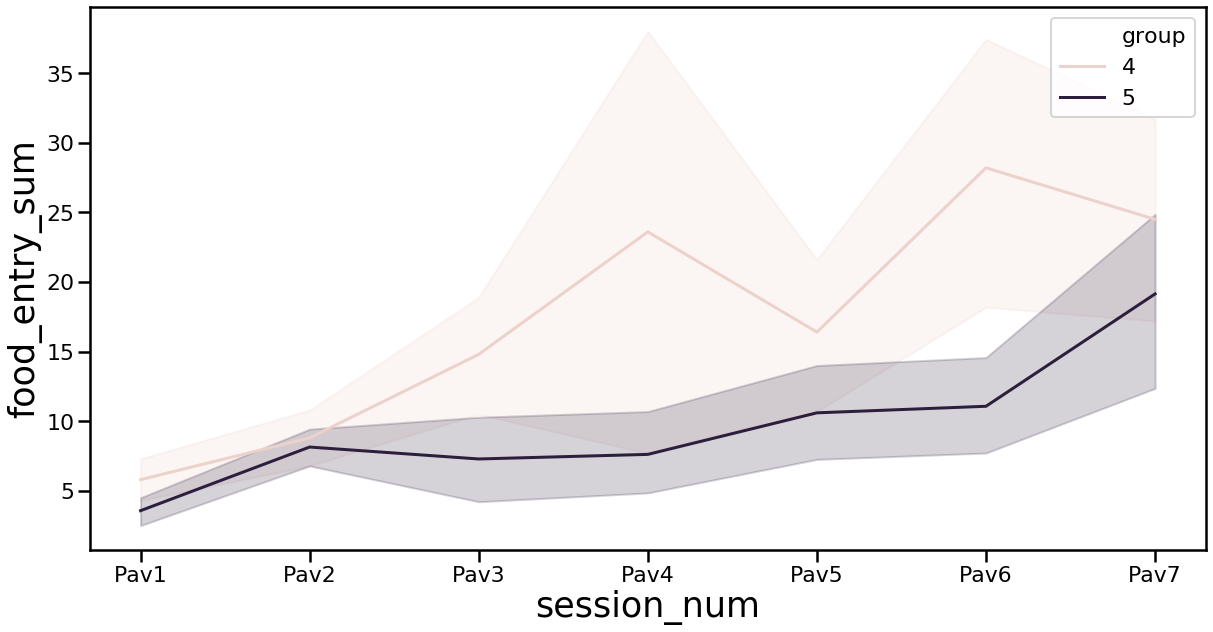

response_bias


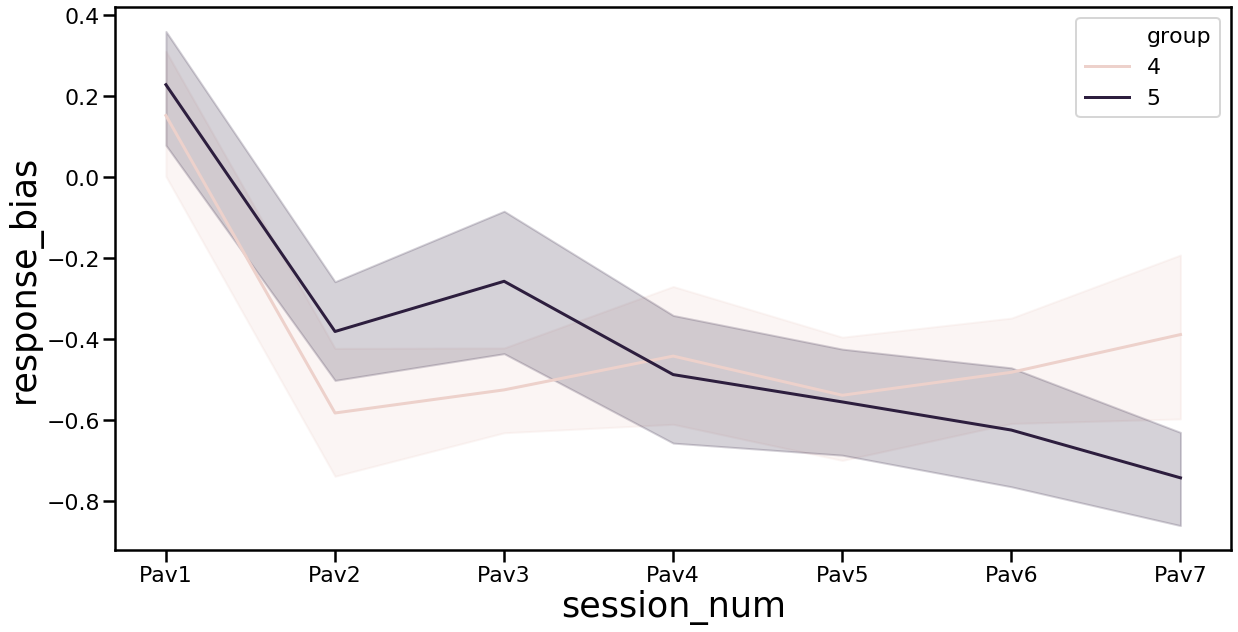

lever_press_trial_count


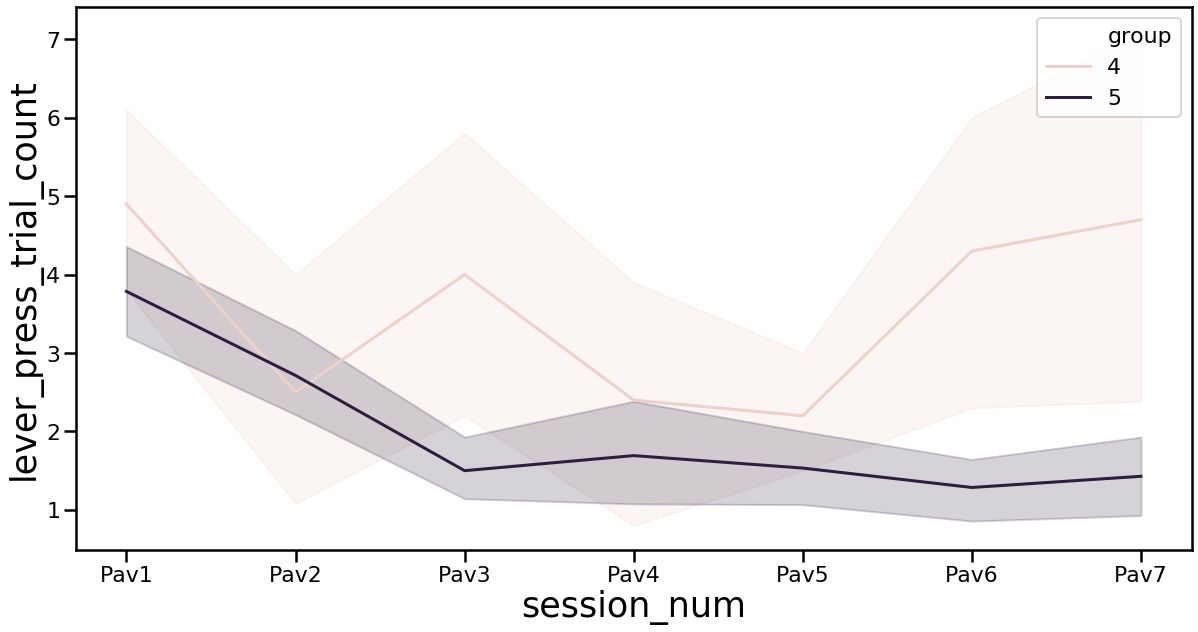

head_entry_trial_count


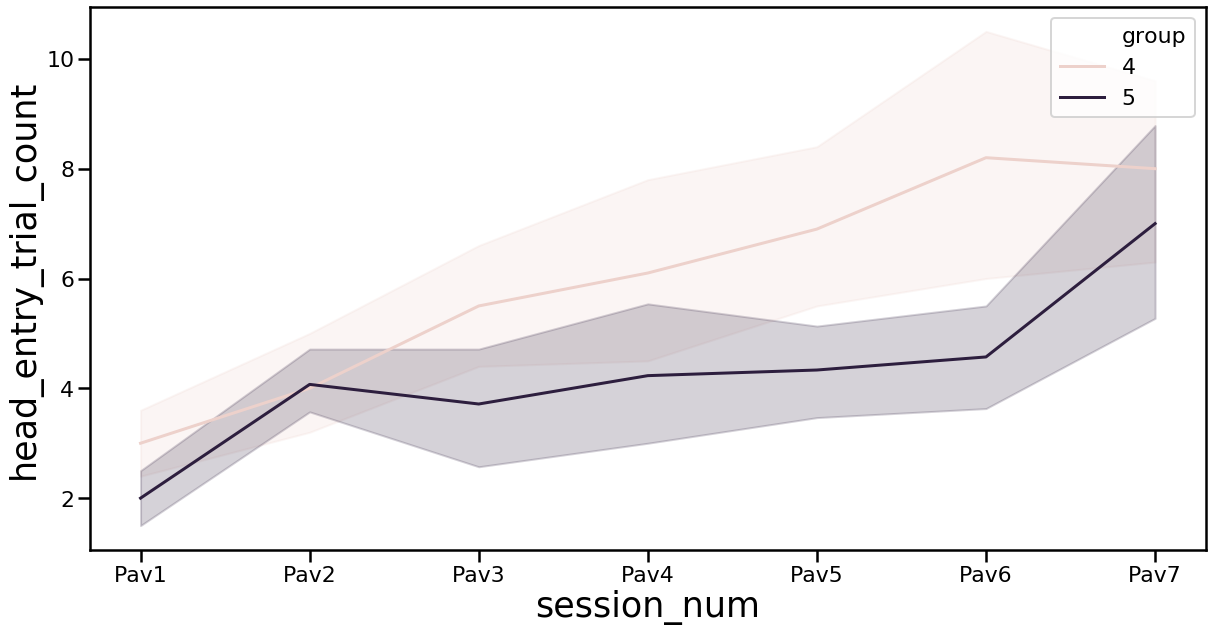

lever_press_prob


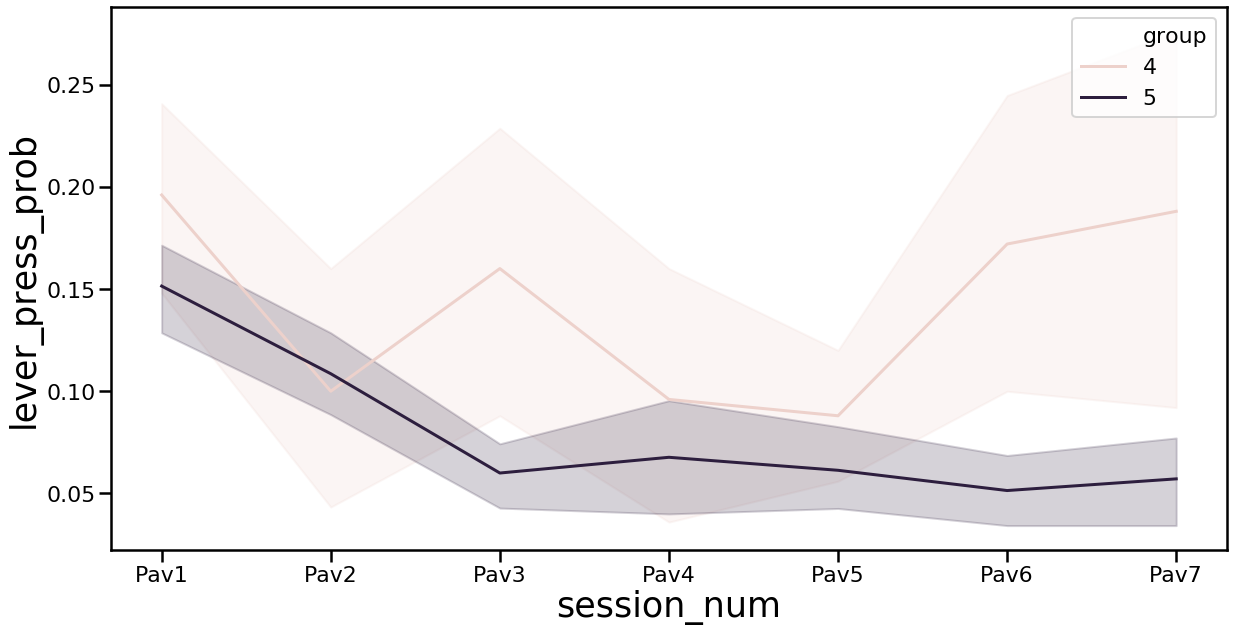

head_entry_prob


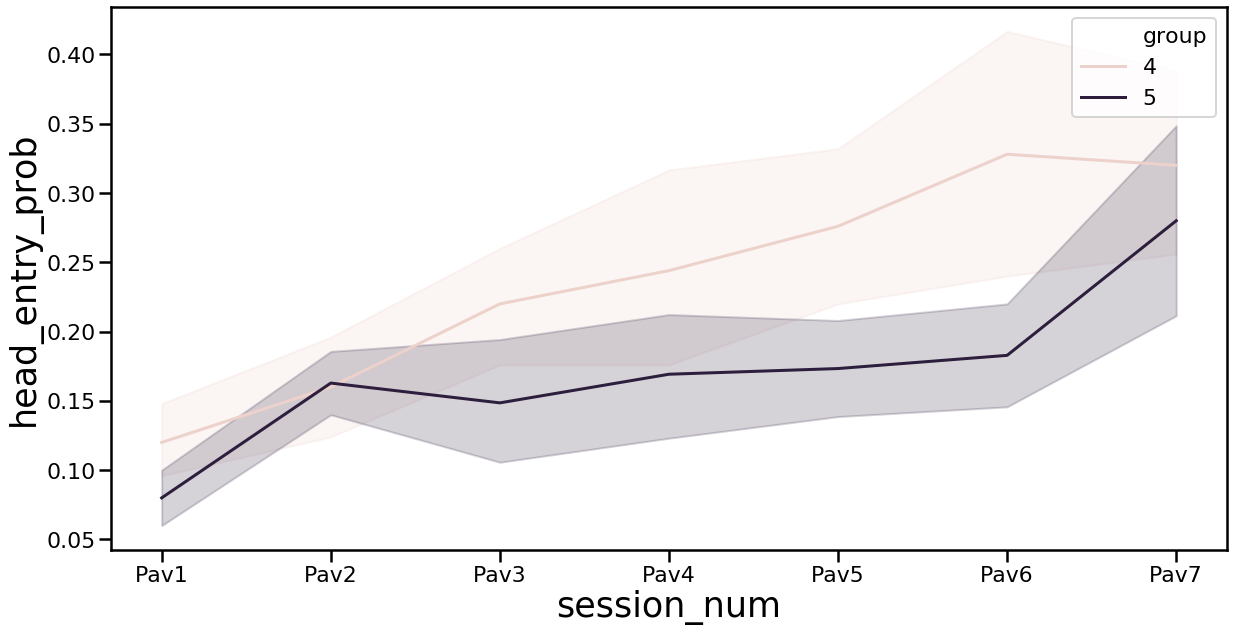

prob_diff


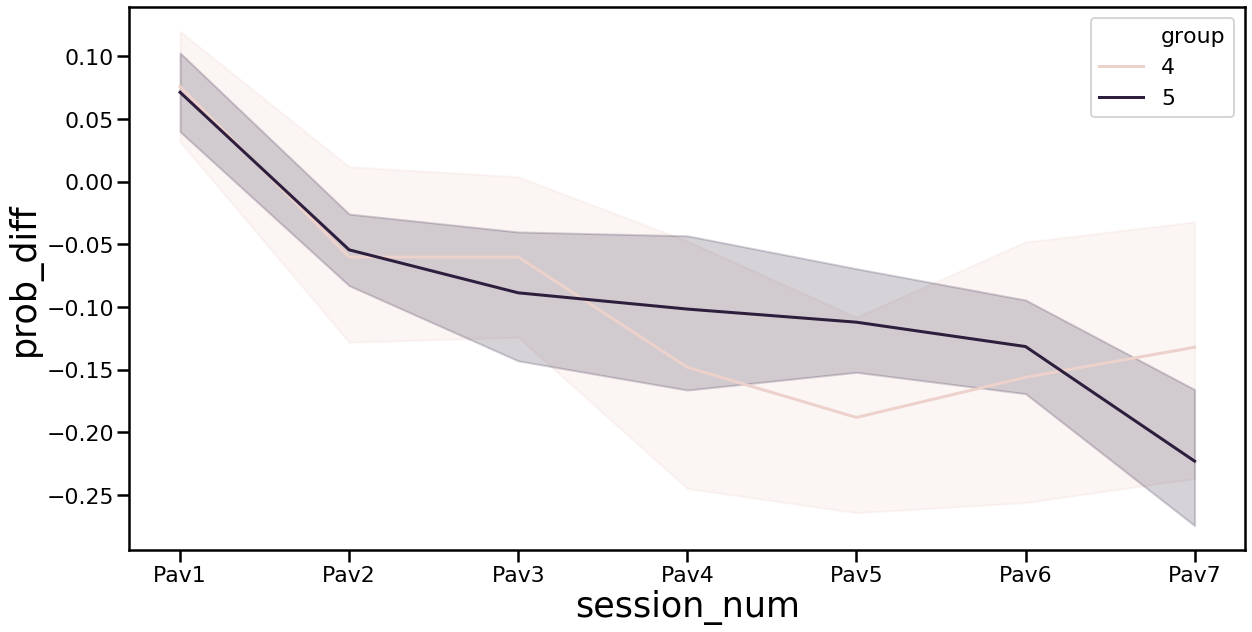

lever_press_lat


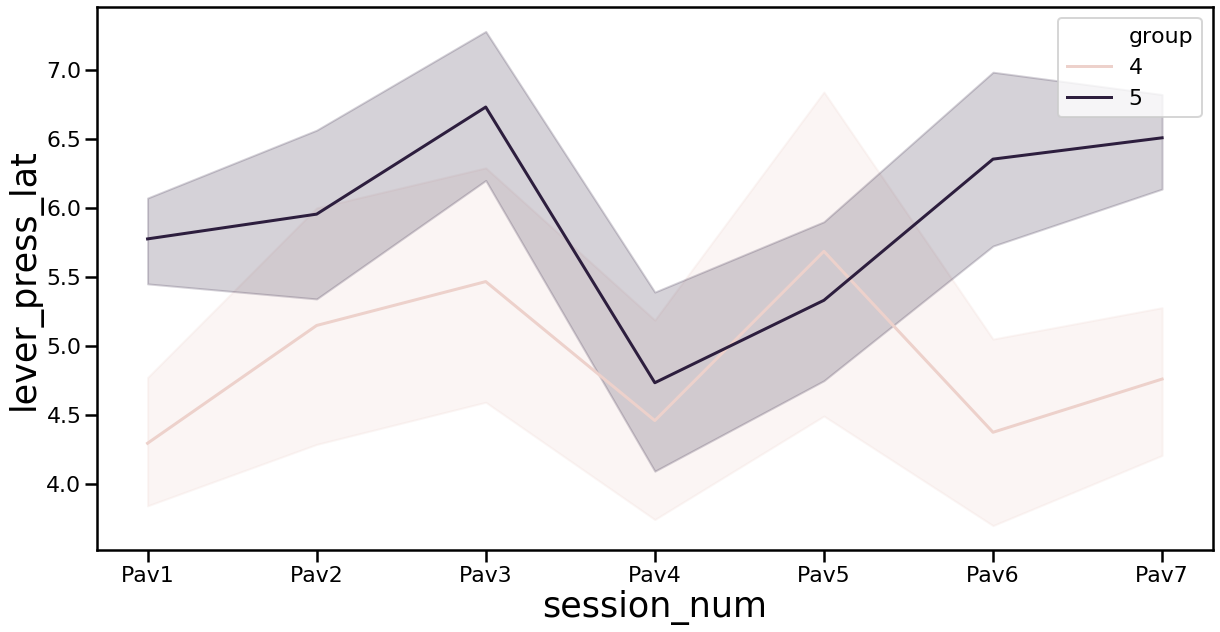

food_entry_lat


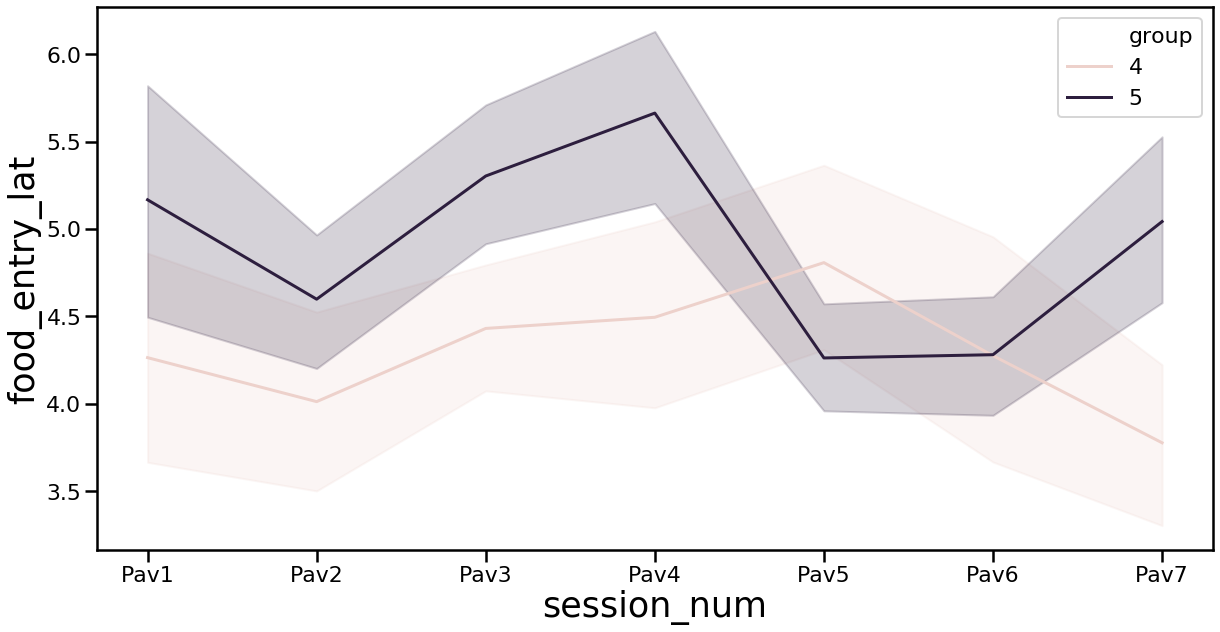

latency_score


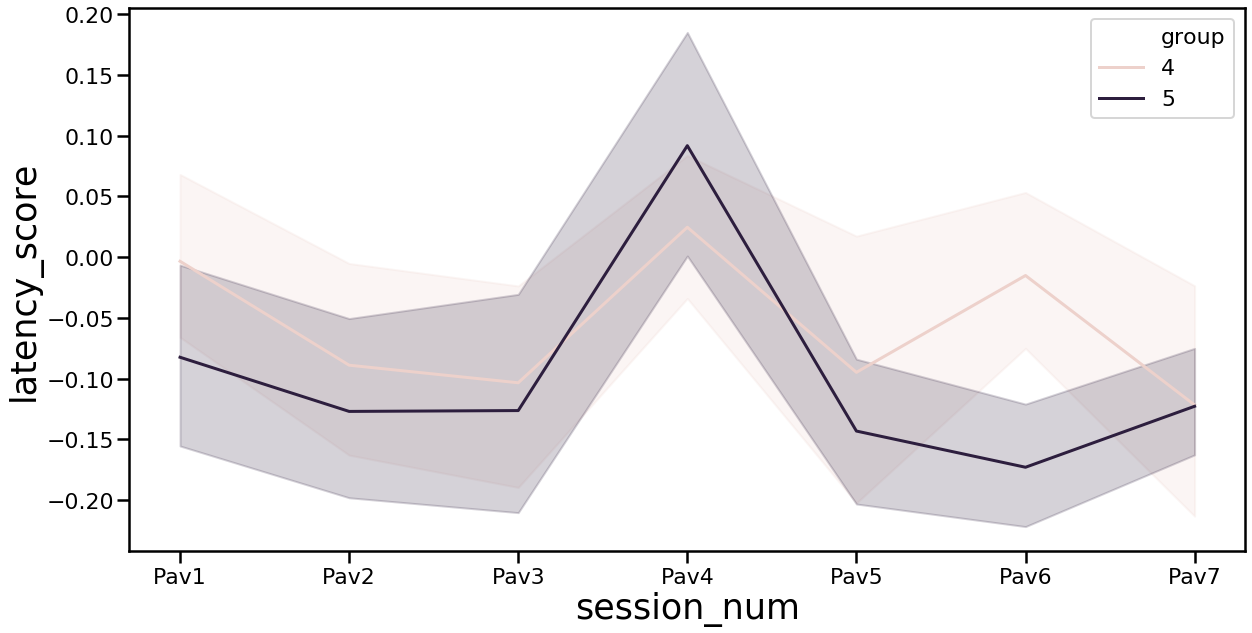

PCA_score


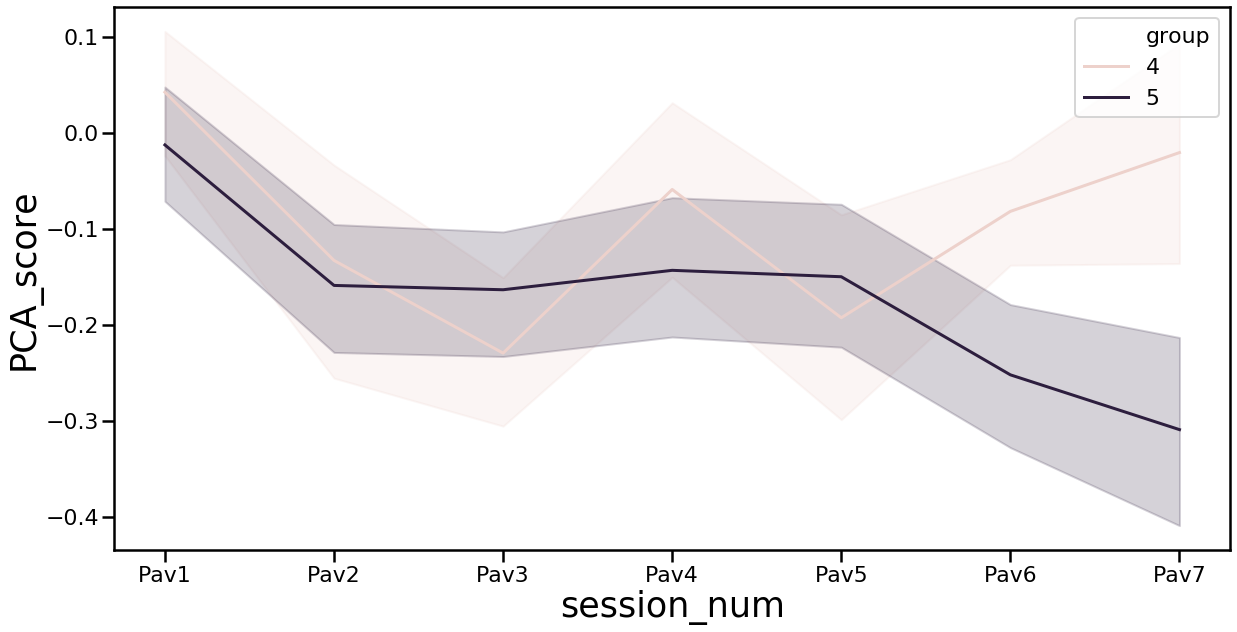

In [55]:
final_data_sessions_sessions = final_data_sessions[final_data_sessions['type'] == 'session']
final_data_sessions_sessions = final_data_sessions_sessions[final_data_sessions_sessions['group'].isin([4,5])]
params = ['lever_press_sum', 'food_entry_sum', 'response_bias', 'lever_press_trial_count', 'head_entry_trial_count', 
          'lever_press_prob', 'head_entry_prob', 'prob_diff', 'lever_press_lat', 'food_entry_lat', 'latency_score', 
          'PCA_score']

for param in params:
    plt.figure(figsize=(20,10))
    print(param)
    sns.lineplot(x='session_num', y=param, data=final_data_sessions_sessions, hue='group', ci=68)
    plt.show()


In [ ]:
file = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/pavlovian/data/round 2 9.2018/Pav/180919_356_Pav2'
bit_dic = {'right_lever': 1, 'left_lever': 2, 'HE': 6}

#proccess file
date, animal_number, session, session_num = get_file_info(file)
array = make_array_from_path(file)
es_et = get_events_and_times(array, "E", "T")
cs_iti = get_trial_times(es_et, 22, 23, 15, 16)
    
trial_data_within = create_trials_df(es_et, cs_iti, 'within')
    
session_data = create_session_df(trial_data_within, bit_dic, 'within')

In [13]:
bit_dic = {'right_lever': 1, 'left_lever': 2, 'HE': 6}
for file in file_paths:

    date, animal_number, session, session_num = get_file_info(file)
    array = make_array_from_path(file)
    es_et = get_events_and_times(array, "E", "T")
    cs_iti = get_trial_times(es_et, 22, 23, 15, 16)
    
    trial_data_within = create_trials_df(es_et, cs_iti, 'within')
    session_data = create_session_df(trial_data_within, bit_dic, 'within')
    
    print(animal_number)
    print(session_data['right_lever_count'].sum())
    print(session_data['left_lever_count'].sum())
    print('\n')

266
4
0


268
6
0


269
0
5


270
6
0


271
0
9


273
0
3


274
6
0


275
0
4


277
2
0


278
0
4


280
12
0


283
0
2


287
13
0


288
0
14


289
1
0


290
0
1


292
0
9


266
0
0


267
0
2


268
2
0


269
0
2


270
1
0


271
0
0


273
0
0


274
5
0


275
0
0


277
3
0


278
0
2


280
5
0


282
2
0


283
0
1


287
10
0


288
0
8


289
3
0


290
0
0


291
5
0


292
0
0


266
2
0


267
0
3


268
2
0


269
0
2


270
1
0


271
0
2


273
0
2


274
1
0


275
0
2


277
3
0


278
0
1


280
1
0


282
11
0


283
0
0


287
11
0


288
0
10


289
3
0


290
0
0


291
7
0


292
0
3


266
0
0


267
0
2


268
2
0


269
0
1


270
2
0


271
0
6


273
0
1


274
1
0


275
0
1


277
3
0


278
0
1


280
5
0


282
0
0


283
0
1


287
20
0


288
0
17


289
0
0


290
0
0


291
6
0


292
0
5


266
0
0


267
0
1


268
3
0


269
0
1


270
2
0


271
0
8


273
0
2


274
1
0


275
0
0


277
5
0


278
0
3


280
2
0


282
1
0


283
0
1


287
13
0


288
0
13


289
0
0


290
0
0


291
5
0


292
0
34


266
3
0


267
0
2


KeyboardInterrupt: 